In [6]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [9]:
import pandas as pd
import os

In [10]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml
from sklearn import datasets

In [11]:
X , y = datasets.load_wine(return_X_y=True)
y[y==1] = 0
y[y==2] = 1


In [12]:
X = StandardScaler().fit_transform(X)


In [13]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(130, 13)
(48, 13)


In [14]:
indices=np.arange(65)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:65]
x_train=np.concatenate((np.array(x_neg[0:65])[indices],x_pos)).reshape(-1,13)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [15]:
x_test = x_neg[65:130].reshape(-1,13)
y_test = y_neg[65:130].reshape(-1,1)

# Standard Bloom Filter

In [1]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [2]:
class BloomFilter:
    
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        
    def add(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            self.bit_array[result] = 1
            
    def lookup(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            if self.bit_array[result] == 0:
                return False
        return True

# Projection model

In [16]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [17]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times,standard_times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start1 = timeit.default_timer()
        
        stanbf = BloomFilter(m,k)
        for x_pos_i in x_pos:
            stanbf.add(sum(x_pos_i))
        
        stop1 = timeit.default_timer()
        
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create Standard: %f - Time Taken to create Projecion: %f \n\n\n" % (m,fpr_test,stop1-start1,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]
        standard_times += [stop1-start1]

In [18]:
num_of_iterations = 5#Increase to make graph smoother

fpr_values = []
size_values = []
times = []
standard_times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times,standard_times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(48, 13)
Size: 10 Bits - FPR: 0.123077 - Time Taken to create Standard: 0.000620 - Time Taken to create Projecion: 0.062412 



Size: 20 Bits - FPR: 0.015385 - Time Taken to create Standard: 0.000446 - Time Taken to create Projecion: 0.076965 



Size: 30 Bits - FPR: 0.046154 - Time Taken to create Standard: 0.000243 - Time Taken to create Projecion: 0.031430 



Size: 40 Bits - FPR: 0.046154 - Time Taken to create Standard: 0.000233 - Time Taken to create Projecion: 0.029874 



Size: 50 Bits - FPR: 0.046154 - Time Taken to create Standard: 0.000332 - Time Taken to create Projecion: 0.042656 



Size: 60 Bits - FPR: 0.076923 - Time Taken to create Standard: 0.000237 - Time Taken to create Projecion: 0.041651 



Size: 70 Bits - FPR: 0.030769 - Time Taken to create Standard: 0.000308 - Time Taken to create Projecion: 0.092351 



Size: 80 Bits - FPR: 0.076923 - Time Taken to create Standard: 0.000432 - Time Taken to create Projecion: 0.031644 



Size: 9

Size: 720 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001538 - Time Taken to create Projecion: 0.076204 



Size: 730 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001207 - Time Taken to create Projecion: 0.121343 



Size: 740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002849 - Time Taken to create Projecion: 0.092807 



Size: 750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000854 - Time Taken to create Projecion: 0.138286 



Size: 760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.014080 - Time Taken to create Projecion: 0.188881 



Size: 770 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006009 - Time Taken to create Projecion: 0.260933 



Size: 780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001221 - Time Taken to create Projecion: 0.108435 



Size: 790 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001479 - Time Taken to create Projecion: 0.253700 



Size: 800 Bits - FPR: 0.000000 - Time Ta

Size: 1410 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001957 - Time Taken to create Projecion: 0.114024 



Size: 1420 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002270 - Time Taken to create Projecion: 0.148258 



Size: 1430 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006399 - Time Taken to create Projecion: 0.317999 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001683 - Time Taken to create Projecion: 0.103514 



Size: 1450 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001613 - Time Taken to create Projecion: 0.133262 



Size: 1460 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001672 - Time Taken to create Projecion: 0.173833 



Size: 1470 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002117 - Time Taken to create Projecion: 0.252381 



Size: 1480 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003302 - Time Taken to create Projecion: 0.169278 



Size: 1490 Bits - FPR: 0.000000 

Size: 2090 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002500 - Time Taken to create Projecion: 0.206583 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005940 - Time Taken to create Projecion: 0.171729 



Size: 2110 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002827 - Time Taken to create Projecion: 0.194430 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004661 - Time Taken to create Projecion: 0.134829 



Size: 2130 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003296 - Time Taken to create Projecion: 0.138834 



Size: 2140 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002485 - Time Taken to create Projecion: 0.133170 



Size: 2150 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002851 - Time Taken to create Projecion: 0.219535 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002746 - Time Taken to create Projecion: 0.194933 



Size: 2170 Bits - FPR: 0.000000 

Size: 2780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002936 - Time Taken to create Projecion: 0.179906 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003592 - Time Taken to create Projecion: 0.409892 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006045 - Time Taken to create Projecion: 0.427594 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.011107 - Time Taken to create Projecion: 0.953718 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.015013 - Time Taken to create Projecion: 0.672390 



Size: 2830 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004008 - Time Taken to create Projecion: 0.191868 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006136 - Time Taken to create Projecion: 0.184062 



Size: 2850 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006120 - Time Taken to create Projecion: 0.194902 



Size: 2860 Bits - FPR: 0.000000 

Size: 460 Bits - FPR: 0.030769 - Time Taken to create Standard: 0.000584 - Time Taken to create Projecion: 0.062516 



Size: 470 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001240 - Time Taken to create Projecion: 0.065888 



Size: 480 Bits - FPR: 0.030769 - Time Taken to create Standard: 0.000623 - Time Taken to create Projecion: 0.064940 



Size: 490 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001038 - Time Taken to create Projecion: 0.065274 



Size: 500 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000666 - Time Taken to create Projecion: 0.075577 



Size: 510 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001053 - Time Taken to create Projecion: 0.057510 



Size: 520 Bits - FPR: 0.046154 - Time Taken to create Standard: 0.001015 - Time Taken to create Projecion: 0.059202 



Size: 530 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000860 - Time Taken to create Projecion: 0.055531 



Size: 540 Bits - FPR: 0.015385 - Time Ta

Size: 1170 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002416 - Time Taken to create Projecion: 0.122622 



Size: 1180 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001371 - Time Taken to create Projecion: 0.129205 



Size: 1190 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002243 - Time Taken to create Projecion: 0.118097 



Size: 1200 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001860 - Time Taken to create Projecion: 0.092370 



Size: 1210 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001335 - Time Taken to create Projecion: 0.102929 



Size: 1220 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001588 - Time Taken to create Projecion: 0.099621 



Size: 1230 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002075 - Time Taken to create Projecion: 0.085255 



Size: 1240 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001333 - Time Taken to create Projecion: 0.132620 



Size: 1250 Bits - FPR: 0.000000 

Size: 1850 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003146 - Time Taken to create Projecion: 0.123960 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002032 - Time Taken to create Projecion: 0.112154 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002335 - Time Taken to create Projecion: 0.114724 



Size: 1880 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002780 - Time Taken to create Projecion: 0.115809 



Size: 1890 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005903 - Time Taken to create Projecion: 0.116747 



Size: 1900 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002208 - Time Taken to create Projecion: 0.117150 



Size: 1910 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002733 - Time Taken to create Projecion: 0.141783 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002237 - Time Taken to create Projecion: 0.123104 



Size: 1930 Bits - FPR: 0.000000 

Size: 2540 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004088 - Time Taken to create Projecion: 0.151206 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003367 - Time Taken to create Projecion: 0.149666 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002744 - Time Taken to create Projecion: 0.151960 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003324 - Time Taken to create Projecion: 0.167982 



Size: 2580 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003321 - Time Taken to create Projecion: 0.151420 



Size: 2590 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002884 - Time Taken to create Projecion: 0.188527 



Size: 2600 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003896 - Time Taken to create Projecion: 0.161421 



Size: 2610 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004241 - Time Taken to create Projecion: 0.156324 



Size: 2620 Bits - FPR: 0.000000 

Size: 250 Bits - FPR: 0.046154 - Time Taken to create Standard: 0.000376 - Time Taken to create Projecion: 0.042333 



Size: 260 Bits - FPR: 0.030769 - Time Taken to create Standard: 0.000380 - Time Taken to create Projecion: 0.039973 



Size: 270 Bits - FPR: 0.092308 - Time Taken to create Standard: 0.000381 - Time Taken to create Projecion: 0.037035 



Size: 280 Bits - FPR: 0.046154 - Time Taken to create Standard: 0.000447 - Time Taken to create Projecion: 0.040910 



Size: 290 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000451 - Time Taken to create Projecion: 0.038418 



Size: 300 Bits - FPR: 0.046154 - Time Taken to create Standard: 0.000444 - Time Taken to create Projecion: 0.039279 



Size: 310 Bits - FPR: 0.015385 - Time Taken to create Standard: 0.000747 - Time Taken to create Projecion: 0.040672 



Size: 320 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000453 - Time Taken to create Projecion: 0.041159 



Size: 330 Bits - FPR: 0.000000 - Time Ta

Size: 940 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001082 - Time Taken to create Projecion: 0.066538 



Size: 950 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001056 - Time Taken to create Projecion: 0.063951 



Size: 960 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001144 - Time Taken to create Projecion: 0.063118 



Size: 970 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001159 - Time Taken to create Projecion: 0.088980 



Size: 980 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001155 - Time Taken to create Projecion: 0.071451 



Size: 990 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001164 - Time Taken to create Projecion: 0.106424 



Size: 1000 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003058 - Time Taken to create Projecion: 0.213703 



Size: 1010 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001570 - Time Taken to create Projecion: 0.073420 



Size: 1020 Bits - FPR: 0.000000 - Time

Size: 1630 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002499 - Time Taken to create Projecion: 0.102194 



Size: 1640 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001969 - Time Taken to create Projecion: 0.099094 



Size: 1650 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003453 - Time Taken to create Projecion: 0.102353 



Size: 1660 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001824 - Time Taken to create Projecion: 0.105686 



Size: 1670 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002245 - Time Taken to create Projecion: 0.096172 



Size: 1680 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002206 - Time Taken to create Projecion: 0.097098 



Size: 1690 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002830 - Time Taken to create Projecion: 0.097450 



Size: 1700 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002591 - Time Taken to create Projecion: 0.127975 



Size: 1710 Bits - FPR: 0.000000 

Size: 2320 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002720 - Time Taken to create Projecion: 0.144529 



Size: 2330 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002853 - Time Taken to create Projecion: 0.369270 



Size: 2340 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002886 - Time Taken to create Projecion: 0.195420 



Size: 2350 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002443 - Time Taken to create Projecion: 0.157859 



Size: 2360 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002495 - Time Taken to create Projecion: 0.155412 



Size: 2370 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004041 - Time Taken to create Projecion: 0.255861 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002580 - Time Taken to create Projecion: 0.134530 



Size: 2390 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002881 - Time Taken to create Projecion: 0.191269 



Size: 2400 Bits - FPR: 0.000000 

Size: 3000 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003304 - Time Taken to create Projecion: 0.256964 



~~~~~~~~ Iteration 4 ~~~~~~~~ 

(48, 13)
Size: 10 Bits - FPR: 0.138462 - Time Taken to create Standard: 0.003699 - Time Taken to create Projecion: 0.125300 



Size: 20 Bits - FPR: 0.107692 - Time Taken to create Standard: 0.000512 - Time Taken to create Projecion: 0.084354 



Size: 30 Bits - FPR: 0.046154 - Time Taken to create Standard: 0.004373 - Time Taken to create Projecion: 0.059855 



Size: 40 Bits - FPR: 0.015385 - Time Taken to create Standard: 0.000307 - Time Taken to create Projecion: 0.066796 



Size: 50 Bits - FPR: 0.046154 - Time Taken to create Standard: 0.001255 - Time Taken to create Projecion: 0.044967 



Size: 60 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000239 - Time Taken to create Projecion: 0.049742 



Size: 70 Bits - FPR: 0.015385 - Time Taken to create Standard: 0.000237 - Time Taken to create Projecion: 0.045400 



Size:

Size: 680 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000803 - Time Taken to create Projecion: 0.125563 



Size: 690 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001427 - Time Taken to create Projecion: 0.070788 



Size: 700 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000864 - Time Taken to create Projecion: 0.095322 



Size: 710 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003298 - Time Taken to create Projecion: 0.135943 



Size: 720 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003411 - Time Taken to create Projecion: 0.151310 



Size: 730 Bits - FPR: 0.015385 - Time Taken to create Standard: 0.001356 - Time Taken to create Projecion: 0.111534 



Size: 740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001298 - Time Taken to create Projecion: 0.058031 



Size: 750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001048 - Time Taken to create Projecion: 0.058981 



Size: 760 Bits - FPR: 0.000000 - Time Ta

Size: 1370 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001670 - Time Taken to create Projecion: 0.087807 



Size: 1380 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002029 - Time Taken to create Projecion: 0.088621 



Size: 1390 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003680 - Time Taken to create Projecion: 0.097397 



Size: 1400 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003270 - Time Taken to create Projecion: 0.100580 



Size: 1410 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001580 - Time Taken to create Projecion: 0.102493 



Size: 1420 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002675 - Time Taken to create Projecion: 0.092213 



Size: 1430 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002055 - Time Taken to create Projecion: 0.116637 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002847 - Time Taken to create Projecion: 0.096621 



Size: 1450 Bits - FPR: 0.000000 

Size: 2050 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002680 - Time Taken to create Projecion: 0.173877 



Size: 2060 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003568 - Time Taken to create Projecion: 0.286211 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002534 - Time Taken to create Projecion: 0.228833 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003739 - Time Taken to create Projecion: 0.205987 



Size: 2090 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003703 - Time Taken to create Projecion: 0.194786 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002503 - Time Taken to create Projecion: 0.137128 



Size: 2110 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002342 - Time Taken to create Projecion: 0.148545 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.004908 - Time Taken to create Projecion: 0.717833 



Size: 2130 Bits - FPR: 0.000000 

Size: 2740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003161 - Time Taken to create Projecion: 0.145097 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002981 - Time Taken to create Projecion: 0.141367 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003499 - Time Taken to create Projecion: 0.154864 



Size: 2770 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003249 - Time Taken to create Projecion: 0.147250 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003536 - Time Taken to create Projecion: 0.147326 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003289 - Time Taken to create Projecion: 0.147568 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003781 - Time Taken to create Projecion: 0.149188 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003236 - Time Taken to create Projecion: 0.160959 



Size: 2820 Bits - FPR: 0.000000 

Size: 420 Bits - FPR: 0.061538 - Time Taken to create Standard: 0.000761 - Time Taken to create Projecion: 0.049708 



Size: 430 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000587 - Time Taken to create Projecion: 0.045662 



Size: 440 Bits - FPR: 0.015385 - Time Taken to create Standard: 0.000592 - Time Taken to create Projecion: 0.044641 



Size: 450 Bits - FPR: 0.046154 - Time Taken to create Standard: 0.000866 - Time Taken to create Projecion: 0.044184 



Size: 460 Bits - FPR: 0.015385 - Time Taken to create Standard: 0.000604 - Time Taken to create Projecion: 0.046136 



Size: 470 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.000901 - Time Taken to create Projecion: 0.104009 



Size: 480 Bits - FPR: 0.015385 - Time Taken to create Standard: 0.001370 - Time Taken to create Projecion: 0.149240 



Size: 490 Bits - FPR: 0.015385 - Time Taken to create Standard: 0.000677 - Time Taken to create Projecion: 0.092212 



Size: 500 Bits - FPR: 0.000000 - Time Ta

Size: 1120 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.009967 - Time Taken to create Projecion: 0.275359 



Size: 1130 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005676 - Time Taken to create Projecion: 0.200504 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003581 - Time Taken to create Projecion: 0.372878 



Size: 1150 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001280 - Time Taken to create Projecion: 0.077580 



Size: 1160 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001274 - Time Taken to create Projecion: 0.095090 



Size: 1170 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001395 - Time Taken to create Projecion: 0.120016 



Size: 1180 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003507 - Time Taken to create Projecion: 0.123028 



Size: 1190 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002725 - Time Taken to create Projecion: 0.214151 



Size: 1200 Bits - FPR: 0.000000 

Size: 1810 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003729 - Time Taken to create Projecion: 0.126717 



Size: 1820 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001986 - Time Taken to create Projecion: 0.104895 



Size: 1830 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002743 - Time Taken to create Projecion: 0.107020 



Size: 1840 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002431 - Time Taken to create Projecion: 0.117180 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002865 - Time Taken to create Projecion: 0.104860 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002273 - Time Taken to create Projecion: 0.104872 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002004 - Time Taken to create Projecion: 0.110054 



Size: 1880 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002141 - Time Taken to create Projecion: 0.109696 



Size: 1890 Bits - FPR: 0.000000 

Size: 2490 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003373 - Time Taken to create Projecion: 0.291523 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006359 - Time Taken to create Projecion: 0.336588 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.006719 - Time Taken to create Projecion: 0.199133 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002931 - Time Taken to create Projecion: 0.140187 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.005158 - Time Taken to create Projecion: 0.281165 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002634 - Time Taken to create Projecion: 0.167526 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002573 - Time Taken to create Projecion: 0.153605 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003482 - Time Taken to create Projecion: 0.141558 



Size: 2570 Bits - FPR: 0.000000 

In [19]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [20]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


In [21]:
total_standard_times = len(standard_times)
average_standard_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += standard_times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_standard_times += [temp]
print(len(average_standard_times))

300


# Normal Bloom Filter Values

In [22]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [23]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

1500
[48]


# FPR Comparison between Projection Model and Normal Bloom Filter

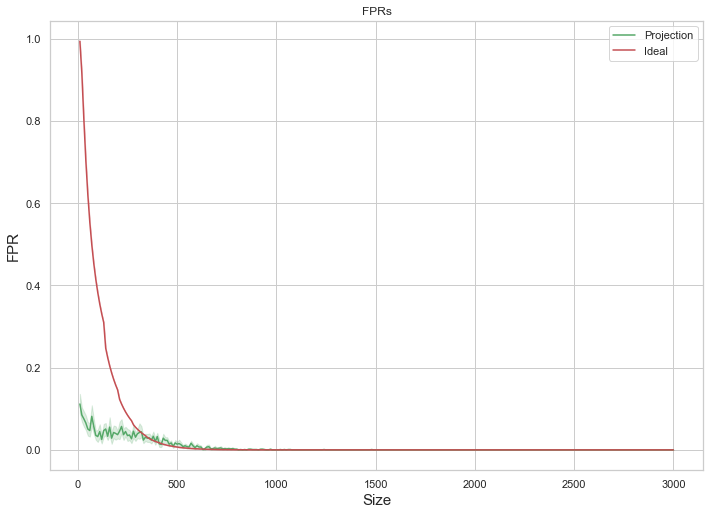

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [22]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [23]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [24]:
print(average_fprs)

[0.11153846153846154, 0.08461538461538463, 0.07538461538461538, 0.06538461538461539, 0.05076923076923077, 0.04692307692307692, 0.08153846153846153, 0.05692307692307693, 0.03538461538461538, 0.0323076923076923, 0.04461538461538461, 0.025384615384615384, 0.04692307692307692, 0.05076923076923077, 0.03307692307692307, 0.055384615384615386, 0.02846153846153846, 0.0423076923076923, 0.04, 0.03692307692307691, 0.04538461538461539, 0.05692307692307692, 0.03692307692307693, 0.04461538461538462, 0.03461538461538462, 0.03615384615384616, 0.026923076923076918, 0.04538461538461539, 0.03076923076923077, 0.039230769230769236, 0.04230769230769231, 0.04384615384615385, 0.023846153846153847, 0.030769230769230764, 0.02846153846153846, 0.029230769230769237, 0.023846153846153847, 0.03307692307692307, 0.02, 0.032307692307692315, 0.014615384615384617, 0.013076923076923078, 0.02846153846153846, 0.023076923076923078, 0.023076923076923078, 0.013846153846153847, 0.016923076923076923, 0.008461538461538461, 0.01692

In [24]:
saved_data = list(zip(size_values, y_ideal, standard_times, average_standard_times, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR','Standard Filter Total Creation Time(sec)', 'Average Standard Filter Total Creation Time(sec)', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Standard Filter Total Creation Time(sec),Average Standard Filter Total Creation Time(sec),Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,0.993637,0.000620,0.001159,0.123077,0.120000,0.062412,0.087072
1,20,0.914742,0.000446,0.000354,0.015385,0.086154,0.076965,0.063923
2,30,0.803536,0.000243,0.001143,0.046154,0.052308,0.031430,0.047917
3,40,0.703366,0.000233,0.000357,0.046154,0.043077,0.029874,0.058348
4,50,0.620815,0.000332,0.000476,0.046154,0.030769,0.042656,0.041921


In [26]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Wine_rerun_epochs_100.csv')